# Skin Cancer BT

## Install MONAI, updata fastai, any other installs go here

In [2]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [3]:
pip install fastai==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 430.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.10
    Uninstalling fastai-2.7.10:
      Successfully uninstalled fastai-2.7.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
base-rbt 0.0.1 requires fastai>=2.7.10, but you have fastai 2.7.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Other installs here
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-_zea4cu7/base-rbt_19d80895e9ad4786a37b8fc43dbeaa9d
  Running command git clone --filter=blob:none --quiet https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-_zea4cu7/base-rbt_19d80895e9ad4786a37b8fc43dbeaa9d
  Resolved https://github.com/hamish-haggerty/base_rbt.git to commit d756d018ff8fd90403720c4de6a0732a0298f4fd
  Preparing metadata (setup.py) ... done
  Using cached fastai-2.7.10-py3-none-any.whl (240 kB)
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.1
    Uninstalling fastai-2.7.1:
      Successfully uninstalled fastai-2.7.1


## Imports

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [6]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

fastai.__version__

'2.7.10'

## Read image filenames from the dataset folders

In [7]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [8]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data

In [9]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None


def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    st=extract_text(i.as_posix())
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1

#sanity check
labels_train = [extract_text(i.as_posix()) for i in fnames_train]
tem_dict = {i:labels_train.count(i) for i in labels_train}
tem_dict

{'pigmented benign keratosis': 100,
 'melanoma': 100,
 'vascular lesion': 100,
 'actinic keratosis': 100,
 'squamous cell carcinoma': 100,
 'basal cell carcinoma': 100,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 100}

## Now get the training dataloader and view the data

In [24]:
#get training set
device ='cuda' if torch.cuda.is_available() else 'cpu'
size=128
n_in=3
ps=1024

bs=512
size=128
item_tfms = [Resize(size)]
dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      num_workers=2*(device=='cuda'),
                                      device=device         
                                    )
x,y = dls_train.one_batch()

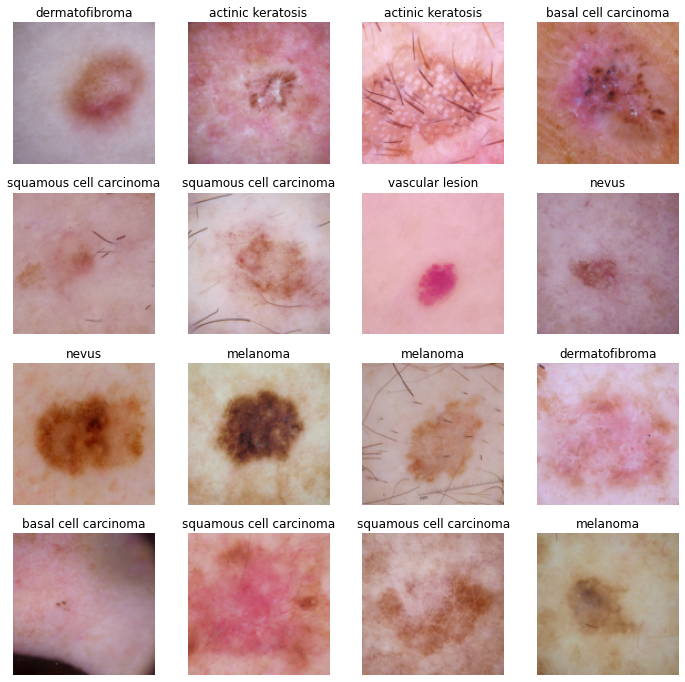

In [14]:
dls_train.show_batch(max_n=16)

## BT stuff now!

In [16]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

In [17]:
#Compute the mean and standard deviation of the dataset: 
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [(channel_sum[i] / num_elements).item() for i in range(3)]
    stddevs = [(((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5).item() for i in range(3)]

    return means, stddevs

means, stddevs = compute_mean_std(dls_train.train)

isic_stats_128 = means,stddevs #when shape is 128
print("Means:", means)
print("Standard deviations:", stddevs)

#Normalize.from_stats(mean=means,std=stddevs)

Means: [0.7609121799468994, 0.5869480967521667, 0.5924641489982605]
Standard deviations: [0.12186530977487564, 0.14097826182842255, 0.15697918832302094]


In [18]:
isic_stats_128

([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],
 [0.12186530977487564, 0.14097826182842255, 0.15697918832302094])

Ok, there is now a question of which augmentations to use...

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.25, 's': 11, 'sig': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.7609]],

         [[0.5869]],

         [[0.5925]]]], device='cuda:0'), 'std': tensor([[[[0.1219]],

         [[0.1410]],

         [[0.1570]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.25, 's': 11, 'sig': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor

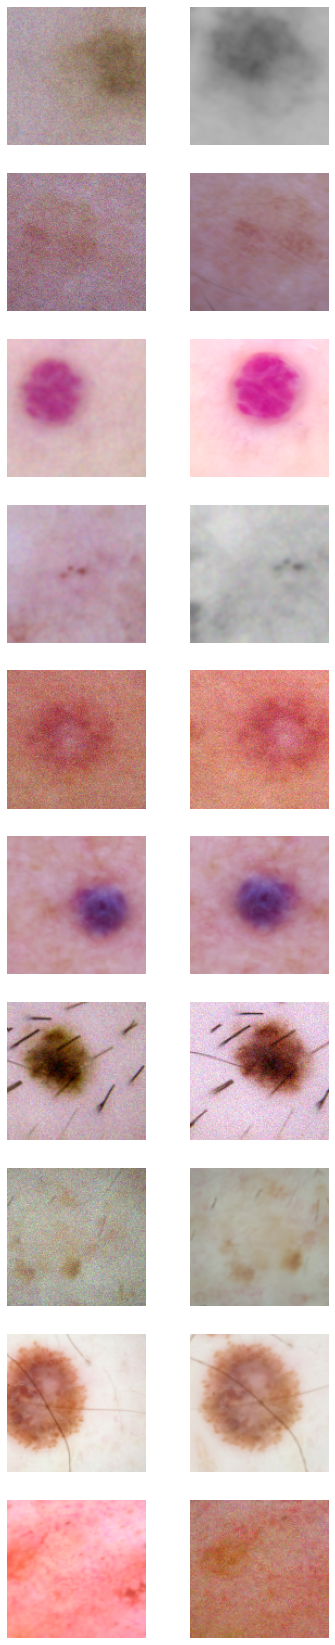

In [19]:
#Ok, there is now a huge question of which augmentations to apply!!!
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.5,2),
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=20,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.25, jitter_p=0.25, bw_p=0.05, blur_p=0.25,sol_p=0.05, #prob of performing aug
                    same_on_batch=False,stats=isic_stats_128, cuda=(device=='cuda'))

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]

#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=3,aug=aug_pipelines,n=10,print_augs=True)

## Train BT

In [26]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
learn.fit(1)

epoch,train_loss,valid_loss,time
0,480.835297,None,00:25
